## Model Evaluation

In [2]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ReLU, MaxPooling2D, Lambda, Input, Layer
from keras.layers import concatenate, Dense, Activation, Dropout, Reshape, Flatten
from keras import optimizers
from keras import losses
from keras import metrics
from keras import backend as K
import os
import numpy as np
from Spatial_Model import create_model

model = create_model()
model.load_weights('spatial_weight.h5')

In [10]:
from datetime import datetime , timedelta

date_start_str = '2018-04-19 22.00.00'
date_end_str = '2018-04-21 23.00.00'

air_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/air_data/"
grid_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/grid_data/"

date_start = datetime.strptime(date_start_str, "%Y-%m-%d %H.%M.%S")
date_end = datetime.strptime(date_end_str, "%Y-%m-%d %H.%M.%S")

file_list = os.listdir(air_folder)
file_date = [a[8:27] for a in file_list]
air_data = [file_list[i] for i,date in enumerate(file_date)  if date >= date_start_str and date <= date_end_str]
air_date = [date for date in file_date if date >= date_start_str and date <= date_end_str]
length = len(air_data)

predict = np.zeros((length-2,3,35))
actual = np.zeros((length-2,3,35))
j = 0
for i, date in enumerate(air_date):
    if i > 1:
        date_curr_str = date
        date_prev_1 = air_date[i-1]
        date_prev_2 = air_date[i-2]
    
        air_map_prev_1 = np.expand_dims(np.load(os.path.join(air_folder,'air_map[' + date_prev_1 + '].npy')), axis = 0)
        air_map_prev_2 = np.expand_dims(np.load(os.path.join(air_folder,'air_map[' + date_prev_2 + '].npy')), axis = 0)
        grid_map = np.expand_dims(np.load(os.path.join(grid_folder,'grid_map[' + date_prev_1 + '].npy')), axis = 0)    
    
        predict[j] = np.floor(model.predict([air_map_prev_2, air_map_prev_1, grid_map])[0])
        actual[j] = np.load(os.path.join(air_folder,'air_map[' + date_curr_str + '].npy'))
        j+=1

SMAPE : 0.240


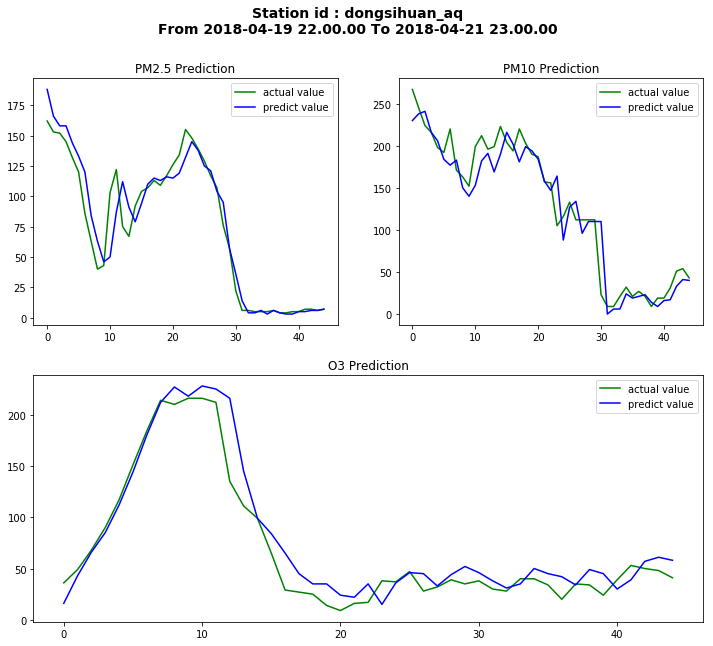

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from evaluation import smape

k = 7
air_station = pd.read_csv('Air_Station_ID.csv')
air_station.sort_values('stationId', inplace = True)

gs = gridspec.GridSpec(2, 2, hspace = 0.2)
fig = plt.figure(figsize=(12,10))
fig.suptitle('Station id : ' + air_station.iloc[[k],[0]].values[0][0] + '\nFrom ' + date_start_str + ' To ' + date_end_str,
             fontsize=14, fontweight='bold')
plt.subplot(gs[0,0])
plt.plot([*range(length-2)], actual[:,0,k], color='g', label='actual value')
plt.plot([*range(length-2)], predict[:,0,k], color='b', label='predict value')
plt.title('PM2.5 Prediction')
plt.legend()

plt.subplot(gs[0,1])
plt.plot([*range(length-2)], actual[:,1,k], color='g', label='actual value')
plt.plot([*range(length-2)], predict[:,1,k], color='b', label='predict value')
plt.title('PM10 Prediction')
plt.legend()

plt.subplot(gs[1,:])
plt.plot([*range(length-2)], actual[:,2,k], color='g', label='actual value')
plt.plot([*range(length-2)], predict[:,2,k], color='b', label='predict value')
plt.title('O3 Prediction')
plt.legend()

smape_score = smape(actual[:,:,k],predict[:,:,k])
print('SMAPE : %.3f'% smape_score)

In [6]:
from datetime import datetime , timedelta

date_start_str = '2017-01-01 00.00.00'
date_end_str = '2018-04-30 23.00.00'

air_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/air_data/"
grid_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/grid_data/"

date_start = datetime.strptime(date_start_str, "%Y-%m-%d %H.%M.%S")
date_end = datetime.strptime(date_end_str, "%Y-%m-%d %H.%M.%S")

file_list = os.listdir(air_folder)
file_date = [a[8:27] for a in file_list]
air_data = [file_list[i] for i,date in enumerate(file_date)  if date >= date_start_str and date <= date_end_str]
air_date = [date for date in file_date if date >= date_start_str and date <= date_end_str]
length = len(air_data)

predict = np.zeros((length-2,3,35))
actual = np.zeros((length-2,3,35))
j = 0
for i, date in enumerate(air_date):
    if i > 1:
        date_curr_str = date
        date_prev_1 = air_date[i-1]
        date_prev_2 = air_date[i-2]
    
        air_map_prev_1 = np.expand_dims(np.load(os.path.join(air_folder,'air_map[' + date_prev_1 + '].npy')), axis = 0)
        air_map_prev_2 = np.expand_dims(np.load(os.path.join(air_folder,'air_map[' + date_prev_2 + '].npy')), axis = 0)
        grid_map = np.expand_dims(np.load(os.path.join(grid_folder,'grid_map[' + date_prev_1 + '].npy')), axis = 0)    
    
        predict[j] = np.floor(model.predict([air_map_prev_2, air_map_prev_1, grid_map])[0])
        actual[j] = np.load(os.path.join(air_folder,'air_map[' + date_curr_str + '].npy'))
        j+=1

In [9]:
import pandas as pd
from evaluation import smape
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import csv

air_station = pd.read_csv('Air_Station_ID.csv')
air_station.sort_values('stationId', inplace = True)

for k in range(35):
    station_name = air_station.iloc[[k],[0]].values[0][0]
    smape_score = smape(actual[:,:,k],predict[:,:,k])
    rmse_score = sqrt(mean_squared_error(actual[:,:,k],predict[:,:,k]))
    print(station_name + ' --- rmse_score : %.3f' % rmse_score + ', smape_score : %.3f' % smape_score)

aotizhongxin_aq --- rmse_score : 21.269, smape_score : 0.234
badaling_aq --- rmse_score : 30.088, smape_score : 0.269
beibuxinqu_aq --- rmse_score : 29.601, smape_score : 0.304
daxing_aq --- rmse_score : 26.134, smape_score : 0.254
dingling_aq --- rmse_score : 28.468, smape_score : 0.226
donggaocun_aq --- rmse_score : 31.681, smape_score : 0.231
dongsi_aq --- rmse_score : 22.804, smape_score : 0.214
dongsihuan_aq --- rmse_score : 23.129, smape_score : 0.279
fangshan_aq --- rmse_score : 31.572, smape_score : 0.251
fengtaihuayuan_aq --- rmse_score : 23.790, smape_score : 0.265
guanyuan_aq --- rmse_score : 21.998, smape_score : 0.240
gucheng_aq --- rmse_score : 24.966, smape_score : 0.250
huairou_aq --- rmse_score : 35.063, smape_score : 0.239
liulihe_aq --- rmse_score : 33.869, smape_score : 0.279
mentougou_aq --- rmse_score : 24.631, smape_score : 0.243
miyun_aq --- rmse_score : 24.262, smape_score : 0.283
miyunshuiku_aq --- rmse_score : 24.064, smape_score : 0.235
nansanhuan_aq --- rms

## Model Prediction Output

In [2]:
from datetime import datetime , timedelta

#model = create_model()
#model.load_weights('spatial_weight.h5')

date_start_str = '2018-05-01 00.00.00'
date_end_str = '2018-05-02 23.00.00'

prediction_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/prediction[Spatial_model]/"
grid_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/grid_data/"

date_start = datetime.strptime(date_start_str, "%Y-%m-%d %H.%M.%S")
date_end = datetime.strptime(date_end_str, "%Y-%m-%d %H.%M.%S")

time_length = int((date_end - date_start)/timedelta(hours = 1))

for i in range((time_length + 1)):
    date_curr = date_start + timedelta(hours = i)
    date_curr_str = date_curr.strftime("%Y-%m-%d %H.%M.%S")
    date_prev_1 = (date_curr - timedelta(hours = 1)).strftime("%Y-%m-%d %H.%M.%S")
    date_prev_2 = (date_curr - timedelta(hours = 2)).strftime("%Y-%m-%d %H.%M.%S")
    
    air_map_prev_1 = np.expand_dims(np.load(os.path.join(prediction_folder,'air_map[' + date_prev_1 + '].npy')), axis = 0)
    air_map_prev_2 = np.expand_dims(np.load(os.path.join(prediction_folder,'air_map[' + date_prev_2 + '].npy')), axis = 0)
    grid_map = np.expand_dims(np.load(os.path.join(grid_folder,'grid_map[' + date_prev_1 + '].npy')), axis = 0)    
    
    prediction = np.floor(model.predict([air_map_prev_2, air_map_prev_1, grid_map])[0])
    np.save(os.path.join(prediction_folder,'air_map[' + date_curr_str + '].npy'),prediction)

In [19]:
import pandas as pd
from datetime import datetime, timedelta
import csv
import numpy as np
import os

air_station_csv_path = 'Air_Station_ID.csv'
prediction_folder = "C:/Users/Juliana/Desktop/msbd5002project_group6/prediction[Spatial_model]/"

with open(air_station_csv_path, 'r') as f:
    reader = csv.reader(f)
    air_stations = list(reader)

air_stations = air_stations[1:]
station_id = sorted([x[0] for x in air_stations])

date_start_str = '2018-05-01 00.00.00'
date_end_str = '2018-05-02 23.00.00'

date_start = datetime.strptime(date_start_str, "%Y-%m-%d %H.%M.%S")
date_end = datetime.strptime(date_end_str, "%Y-%m-%d %H.%M.%S")

time_length = int((date_end - date_start)/timedelta(hours = 1))

column_names = ['test_id','PM2.5','PM10','O3']
#df = pd.DataFrame(columns = column_names)
#df = df.astype({"test_id": str, "PM2.5": int, "PM10": int, "O3": int})

temp = []
for k in range(len(station_id)):
    for i in range(time_length + 1):
        date_curr = date_start + timedelta(hours = i)
        date_curr_str = date_curr.strftime("%Y-%m-%d %H.%M.%S")
        air_map = np.load(os.path.join(prediction_folder,'air_map[' + date_curr_str + '].npy'))
        temp.append([station_id[k] + "#" + str(i), int(air_map[0][k]), int(air_map[1][k]), int(air_map[2][k])])

df = pd.DataFrame(temp,columns = column_names)
df.to_csv('CNN Model Prediction Result.csv', index = False)